# Accelerating Matrix Multiplication

## Preliminaries

If you want to re-generate the results, please hit 'Run All Cells' now (it can take a few minutes).

Below is a raw-`Python` implementation of element-wise matrix addition and subtraction. 
While this is much more efficiently implemented in `numpy`, usage of accelerated library functions would skew our results, so we will be using this throughout.
The only library functionality we employ is the `array`, as a datastructure to store matrices. 

In [278]:
!pip install time numpy matplotlib tqdm joblib

import time 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed

ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


In [175]:
def assert_similar(A,B):
    """
    Check if two matrices are similar. 
    Return their dimensions if they are.
    """
    n, m = A.shape[0], A.shape[1]
    if n != B.shape[0] or m != B.shape[1]:
        raise ValueError("Matrices must have the same dimensions!")
    return n, m

def addm(A,B):
    """
    Add two similar matrices, A and B.
    """
    n, m = assert_similar(A,B)
    C = np.empty((n,m))
    for i in range(n):
        for j in range(m):
            C[i,j] = A[i,j] + B[i,j]
    return C

def subm(A,B):
    """
    Subtract two similar matrices, A and B.
    """
    n, m = assert_similar(A,B)
    C = np.empty((n,m))
    for i in range(n):
        for j in range(m):
            C[i,j] = A[i,j] - B[i,j]
    return C

### Rings

Briefly, a *ring* $\mathcal{R}=\langle\mathbb{S},\oplus,\otimes,\ominus,\mathbb{0},\mathbb{1}\rangle$ is a set $\mathbb{S}$ (e.g. $\mathbb{R}$) equipped with 
* associative, commutative *addition* $\oplus$
* associative, right- and left-distributive *multiplication* $\otimes$
* additive *inversion* $\ominus$, such that $a\oplus \ominus(a)=\mathbb{0} \ \forall \ a \in \mathbb{S}$
* additive identity $\mathbb{0}$, such that $a\oplus\mathbb{0}=a \ \forall \ a \in \mathbb{S}$
* multiplicative identity $\mathbb{1}$, such that $a\otimes\mathbb{1}=a \ \forall \ a \in \mathbb{S}$

Two salient examples:
* a ring on the real numbers is defined by $\langle\mathbb{R},+,\times,-,0,1\rangle$
* a ring on the set of matrices $\mathbf{M}\in \mathbb{R}^{n\times n}$ is defined by $\langle\mathbb{R}^{n\times n},\times_m,+_{ew},-_{ew},\text{diag}(0),\text{diag}(1)\rangle$, where
    * $+_{ew}$ is element-wise addition
    * $-_{ew}$ is element-wise multiplication by -1
    * $\times_m$ is matrix multiplication

## Naive Matrix Multiplication

For two $(n\times n)$ matrices $\mathbf{A}, \mathbf{B}$ over a ring $\mathcal{R}=\langle\mathbb{S},\oplus,\otimes,\ominus,\mathbb{0},\mathbb{1}\rangle$, naive matrix multiplication $\mathbf{C}=\mathbf{A}\mathbf{B}$ using the schoolbook ('row-times-column') algorithm $c_{ij}=\mathbf{a}_{i:}^\intercal\mathbf{b}_{:j}=\oplus_{k=1}^{n} a_{ik}\otimes b_{kj}$ requires $n$ multiplications and $(n-1)$ additions for each of the $n^2$ elements of $\mathbf{C}$, and therefore requires $n^2(n+(n-1))=2n^3-n^2\in \mathcal{O}(n^3)$ operations overall.

To illustrate, for two $(2\times 2)$-matrices, we have

$$
\mathbf{A} = \begin{bmatrix} B_{11} & B_{12} \\
                             B_{21} & B_{22}
                \end{bmatrix};\quad
\mathbf{B} = \begin{bmatrix} B_{11} & B_{12} \\
                             B_{21} & B_{22}
                \end{bmatrix}
 \quad \Rightarrow \quad 
\mathbf{C} = \mathbf{A}\mathbf{B} = 
\begin{bmatrix}
B_{11} {\color{red}\otimes} B_{11} \oplus B_{12} {\color{red}\otimes} B_{21} \quad &
B_{11} {\color{red}\otimes} B_{12} \oplus B_{12} {\color{red}\otimes} B_{22} \\
B_{21} {\color{red}\otimes} B_{11} \oplus B_{22} {\color{red}\otimes} B_{21} \quad &
B_{21} {\color{red}\otimes} B_{12} \oplus B_{22} {\color{red}\otimes} B_{22}
\end{bmatrix}.
$$

In raw `Python` (avoiding special library functions) we can write something like:

In [176]:
def naive_mult(A, B):
    """
    Multiply two matrices, A and B, using the naive method.
    Also count the number of multiplications and additions.
    """
    if A.shape[1] != B.shape[0]:
        raise ValueError("Incompatible shapes for matrix multiplication: %s and %s" % (A.shape, B.shape))
    
    num_mults, num_adds = 0, 0
    C = np.empty((A.shape[0], B.shape[1]))

    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                # this cumbersome structure ensures proper operation counting
                if k == 0:
                    C[i, j] = A[i, k] * B[k, j]
                    num_mults += 1
                else:
                    C[i, j] += A[i, k] * B[k, j]
                    num_mults += 1
                    num_adds += 1

    return C, num_mults, num_adds

## Strassen's Algorithm

The earliest improvement on the naive algorithm was [published in 1967 by Strassen](https://doi.org/10.1007/BF02165411), who showed that, for $(2\times 2)$-matrices
$$
\mathbf{A} = \begin{bmatrix} A_{11} & A_{12} \\
                             A_{21} & A_{22}
                \end{bmatrix};\quad
\mathbf{B} = \begin{bmatrix} B_{11} & B_{12} \\
                             B_{21} & B_{22}
                \end{bmatrix},
$$
it is possible to arrive at the result $\mathbf{A}\mathbf{B}$ with just seven multiplications, rather than the expected eight, at the expense of additional additions (which are usually more efficient to compute). In particular, one defines
$$
\begin{align*}
M_1 &= (A_{11} \oplus A_{22}) {\color{red}\otimes} (B_{11} \oplus B_{22}); \\
M_2 &= (A_{21} \oplus A_{22}) {\color{red}\otimes} B_{11}; \\
M_3 &= A_{11} {\color{red}\otimes} (B_{12} \oplus \ominus(B_{22})); \\
M_4 &= A_{22} {\color{red}\otimes} (B_{21} \oplus \ominus(B_{11})); \\
M_5 &= (A_{11} \oplus A_{12}) {\color{red}\otimes} B_{22}; \\
M_6 &= (A_{21} \oplus \ominus(A_{11})) {\color{red}\otimes} (B_{11} \oplus B_{12}); \\
M_7 &= (A_{12} \oplus \ominus (A_{22})) {\color{red}\otimes} (B_{21} \oplus B_{22}), \\
\end{align*}
$$,
and then computes
$$
\mathbf{C} =
\begin{bmatrix}
C_{11} & C_{12} \\
C_{21} & C_{22}
\end{bmatrix}
=
\begin{bmatrix}
M_1 \oplus M_4 \oplus \ominus(M_5) \oplus M_7 \quad &
M_3 \oplus M_5 \\
M_2 \oplus M_4 \quad &
M_1 \oplus\ominus(M_2) \oplus M_3 \oplus M_6
\end{bmatrix}.
$$

The savings compound, because the algorithm can be applied recursively. For example, a $(4\times 4)$-matrix is a $(2\times 2)$-matrix whose elements are themselves $(2\times 2)$-matrices, i.e. a matrix on $\langle\mathbb{R}^{2\times 2},\times_m,+_{ew},-_{ew},\text{diag}(0),\text{diag}(1)\rangle$ to which the Strassen algorithm applies.
$$
\mathbf{A} = \left[ \begin{array}{cc|cc}   A_{11} & A_{12} & A_{13} & A_{14}\\
                             A_{21} & A_{22} & A_{23} & A_{24}\\
                             \hline
                             A_{31} & A_{32} & A_{33} & A_{34}\\
                             A_{41} & A_{42} & A_{43} & A_{44}\\
                \end{array}\right]
            = \begin{bmatrix} \tilde{A}_{11} & \tilde{A}_{12} \\
                             \tilde{A}_{21} & \tilde{A}_{22}
                \end{bmatrix} ;\quad
\mathbf{B} = \left[ \begin{array}{cc|cc}   B_{11} & B_{12} & B_{13} & B_{14}\\
                             B_{21} & B_{22} & B_{23} & B_{24}\\
                             \hline
                             B_{31} & B_{32} & B_{33} & B_{34}\\
                             B_{41} & B_{42} & B_{43} & B_{44}\\
                \end{array}\right] 
            = \begin{bmatrix} \tilde{B}_{11} & \tilde{B}_{12} \\
                             \tilde{B}_{21} & \tilde{B}_{22}
                \end{bmatrix} ;\quad
$$
Similarly, an $(8\times 8)$-matrix is a $(2\times 2)$-matrix on $\langle\mathbb{R}^{4\times 4},\times_m,+_{ew},-_{ew},\text{diag}(0),\text{diag}(1)\rangle$, to which the algorithm applies, and so on for all powers of $2$. Matrices of any size $(n\times m)$ can be treated by padding them out with zeros to be a square of side length the closest power of $2$.

In `Python`, we can therefore write:

In [216]:
def pad_to_power_two(A, B):
    """
    Pad the input matrices A and B with zeros to the nearest power of 2, 
    such that they have the same final shape of (2^k x 2^k).
    """
    n = max(A.shape[0], A.shape[1], B.shape[0], B.shape[1])
    n_new = int(2**np.ceil(np.log2(n)))
    A_new, B_new = [np.zeros((n_new, n_new), 
                             dtype=max(A.dtype, B.dtype)) for i in range(2)]
    A_new[:A.shape[0], :A.shape[1]] = A
    B_new[:B.shape[0], :B.shape[1]] = B
    return A_new, B_new, n_new

def strassen_mult_rec(A, B, base_case=1):
    """
    Strassen's algorithm for matrix multiplication (recursive). 
    Also counts the number of multiplications and additions.
    """
    if A.shape[0] <= base_case:
        # for base_case = 1 this is scalar multiplication 
        return naive_mult(A,B) 
    else:
        A, B, n = pad_to_power_two(A, B)
        A11, A12, A21, A22 = A[:n//2, :n//2], A[:n//2, n//2:], A[n//2:, :n//2], A[n//2:, n//2:]
        B11, B12, B21, B22 = B[:n//2, :n//2], B[:n//2, n//2:], B[n//2:, :n//2], B[n//2:, n//2:]

        # recursive calls
        M1, m1, a1 = strassen_mult_rec(addm(A11,A22), addm(B11,B22))
        M2, m2, a2 = strassen_mult_rec(addm(A21,A22), B11)
        M3, m3, a3 = strassen_mult_rec(A11, subm(B12,B22))
        M4, m4, a4 = strassen_mult_rec(A22, subm(B21,B11))
        M5, m5, a5 = strassen_mult_rec(addm(A11,A12), B22)
        M6, m6, a6 = strassen_mult_rec(subm(A21,A11), addm(B11,B12))
        M7, m7, a7 = strassen_mult_rec(subm(A12,A22), addm(B21,B22))

        num_mult = sum([m1, m2, m3, m4, m5, m6, m7])
        num_adds = sum([a1, a2, a3, a4, a5, a6, a7])

        # correct number of additions for matrix-adds before recursive calls
        for i in [a1, a6, a7]:
            num_adds += 2*(n//2)**2
        for i in [a2, a3, a4, a5]:
            num_adds += (n//2)**2

        # combine the results
        C11 = addm(subm(addm(M1, M4),M5),M7)
        C12 = addm(M3, M5)
        C21 = addm(M2, M4)
        C22 = addm(addm(subm(M1, M2), M3), M6)
        C = np.vstack([np.hstack([C11, C12]), np.hstack([C21, C22])])

        # correct number of additions for matrix-adds just performed
        for i in [C11, C22]:
            num_adds += 3*(n//2)**2
        for i in [C12, C21]:
            num_adds += (n//2)**2

        return C, num_mult, num_adds

def strassen(A, B, base_case=1):
    """
    Wrapper for Strassen's algorithm.
    Does input validation and un-pads the result.
    """
    if A.shape[1] != B.shape[0]:
        raise ValueError("Incompatible shapes for matrix multiplication: %s and %s" % (A.shape, B.shape))
    C, mults, adds = strassen_mult_rec(A, B, base_case=base_case)
    return C[:A.shape[0], :B.shape[1]], mults, adds

### Time & Space Complexity

Each call to the Strassen algorithm spawns seven recursive calls and additionally involves 18 additions of matrices of size $(\frac{n}{2}\times\frac{n}{2})$. Assuming $n=2^k;\ k\in \mathbb{Z}$, the total number of operations can hence be recursively formulated as
$$
\begin{align*}
f(2^k) &= 7\cdot f(2^{k-1}) + 18\cdot(2^{k-1})^2 \\
       &= 7^k + 18\cdot\sum_{i=1}^{k}7^{i-1}(2^{k-i})^2 \\
       &= 7^k + \frac{18}{3}(7^k-4^k) \\
       &= 7n^{\log_2{7}} - 6n^2 \in \mathcal{O}(n^{\log_2{7}})=\mathcal{O}(n^{2.8\dots}),
\end{align*}
$$
where we have telescoped the initial expression, applied the closed-form expression for the geometric series, and used the identities $7^k=(2^{log_2{7}})^k=n^{log_2{7}}$ and $4^k=(2^2)^k=(2^k)^2=n^2$.

That is, Strassen's algorithm requires asymptotically fewer operations than naive matrix operation, but the crossover point $7n^{\log_2{7}} - 6n^2 = 2n^3-n^2$ lies at around $n=654$.

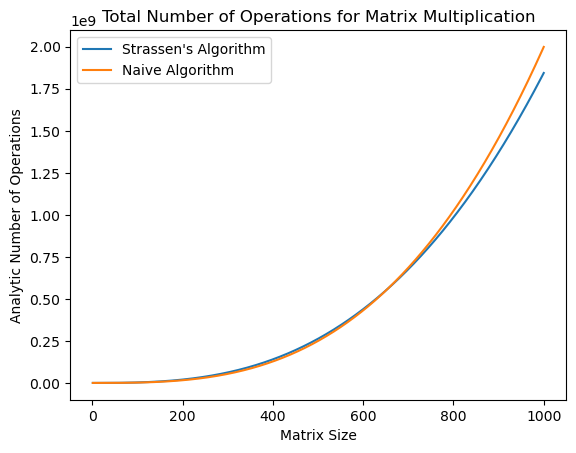

In [208]:
x = np.linspace(1, 1000, 1000)
naive = [2*n**3-n**2 for n in x]
strassen = [7*n**np.log2(7)-6*n**2 for n in x]
plt.plot(x, strassen, label="Strassen's Algorithm")
plt.plot(x, naive, label="Naive Algorithm")
plt.xlabel("Matrix Size")
plt.ylabel("Analytic Number of Operations")
plt.title("Total Number of Operations for Matrix Multiplication")
plt.legend()
plt.show()

As scalar multiplication generally takes longer to compute than addition, even on modern machines, it should be noted that savings can theoretically be observed even for matrices smaller than $n=654$, because Strassen employs fewer multiplications at any $n$. At what point exactly this leads to CPU-time reduction depends on just how much slower multiplication is, relative to addition, on any given system.

Practically speaking, however, on most systems the processing bottleneck is not usually CPU speed, but the (much slower) memory operations required. 
Strassen's algorithm requires both strictly more memory capacity (if, asymptotically, in the same complexity class), and more operations within that memory.
Specifically, the naive algorithm must allocate $3n^2\in \mathcal{O}(n^2)$ space for the two input matrices and the output matrix. 
Strassen's algorithm requires the same space, plus–at least–an additional $2(\frac{n}{2})^2\in \mathcal{O}(n^2)$, which is used to store the inputs to each recursive call. This is sufficient space overall, if the auxiliary matrices $\mathbf{M}_i$ are computed successively, with the outputs written directly into the relevant cells of $\mathbf{C}$. 

In the interest of code clarity, the above implementation requires additional space (because the $\mathbf{M}_i,\ \mathbf{C}_{ij}$ are stored simultaneously), and also introduces further memory requirements to manage the call-stack. All this adds considerably to the runtime, as the below experiment demonstrates.

In [198]:
sizes = [2**i for i in range(9)]
s_mults, s_adds, s_t, n_mults, n_adds, n_t = [], [], [], [], [], []
for n in tqdm(sizes):
    A, B = [np.random.rand(n, n) for j in range(2)]
    
    t1 = time.time()
    C1, mults1, adds1 = strassen(A, B)
    t_es = time.time() - t1

    t2 = time.time()
    C2, mults2, adds2 = naive_mult(A, B)
    t_en = time.time() - t2

    s_mults.append(mults1); s_adds.append(adds1)
    n_mults.append(mults2); n_adds.append(adds2)
    s_t.append(t_es); n_t.append(t_en)
    assert(np.allclose(C1, C2))

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [01:48<00:00, 12.00s/it]


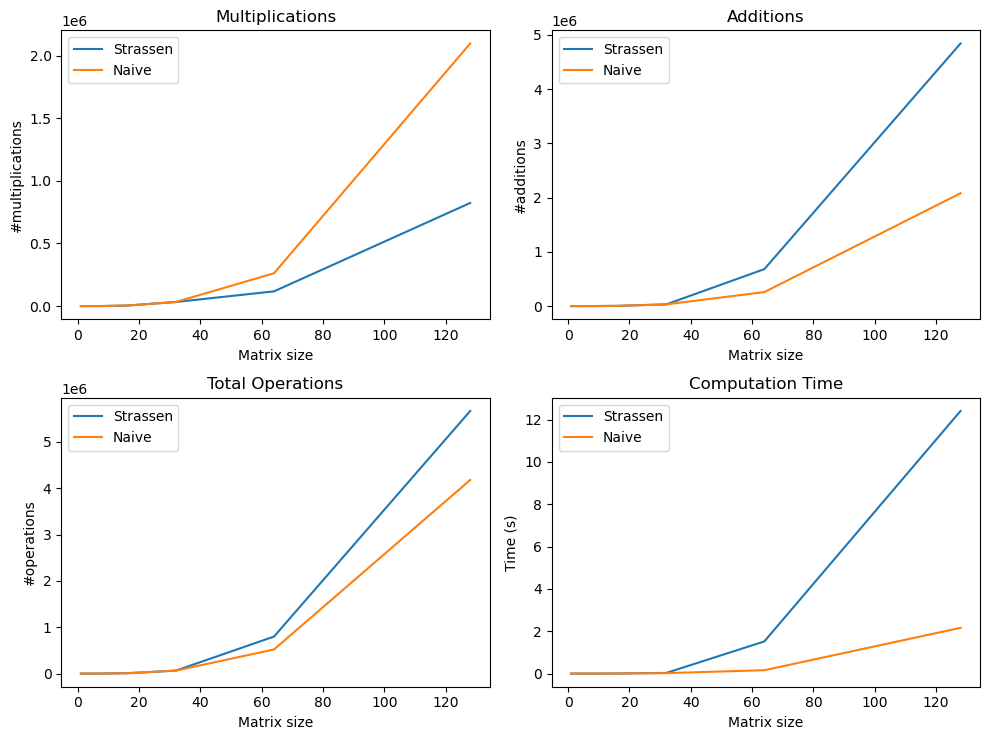

In [231]:
fig, ax = plt.subplots(2,2, figsize=(10,7.5))

ax[0,0].plot(sizes, s_mults, label="Strassen")
ax[0,0].plot(sizes, n_mults, label="Naive")
ax[0,0].set_xlabel("Matrix size")
ax[0,0].set_ylabel("#multiplications")
ax[0,0].set_title("Multiplications")
ax[0,0].legend()

ax[0,1].plot(sizes, s_adds, label="Strassen")
ax[0,1].plot(sizes, n_adds, label="Naive")
# ax[0,1].plot(sizes, 6*np.array(sizes)**np.log2(7)-6*np.array(sizes)**2, label="Analytic")
ax[0,1].set_xlabel("Matrix size")
ax[0,1].set_ylabel("#additions")
ax[0,1].set_title("Additions")
ax[0,1].legend()

ax[1,0].plot(sizes, np.array(s_mults)+np.array(s_adds), label="Strassen")
ax[1,0].plot(sizes, np.array(n_mults)+np.array(n_adds), label="Naive")
# ax[1,0].plot(sizes, 7*np.array(sizes)**np.log2(7)-6*np.array(sizes)**2, label="Analytic")
ax[1,0].set_xlabel("Matrix size")
ax[1,0].set_ylabel("#operations")
ax[1,0].set_title("Total Operations")
ax[1,0].legend()

ax[1,1].plot(sizes, s_t, label="Strassen")  
ax[1,1].plot(sizes, n_t, label="Naive")
ax[1,1].set_xlabel("Matrix size")
ax[1,1].set_ylabel("Time (s)")
ax[1,1].set_title("Computation Time")
ax[1,1].legend()
plt.tight_layout()
plt.show()

Notice how the Strassen runtime for the largest matrix is around eight-fold that of the naive algorithm, whereas the difference in the number of overall operations is much smaller (we are in the $n<654$ regime in all cases).

### Improvements and Modifications

Because Strassen's algorithm only yields tangible time-savings for memory-efficient implementations and 'large' matrices ($(n_{crit}\times n_{crit})$, where this critical size depends on the system's memory architecture, in practice), it should be stressed that it is not necessary to recurse all the way down to scalars. 
Instead, one can Strassen-split the matrices until one reaches the critical size, then perform the (faster) naive algorithm at that level.
In the code above, this corresponds to setting a `base_case>1`. 
Unfortunately the critical size for my system and this (very didactic) `Python` implementation is so large, that it could not be determined in the time provided. 
An implementation in `C++` might lend itself better to such a task.

Because one can stop the recursion before reaching a $(1\times 1)$-matrix, it is also unneccesary to pad to a size that is a power of $2$. Instead, one can, for example, pad to the next even number, Strassen-split until an odd-numbered dimensionality is reached, pad again, and so on. This significantly reduces the memory difference to the standard algorithm for cases where the input matrices are not $(2^k\times 2^k)$.

## Other Ways of Accelerating Matrix Multiplication

### Other Algorithms

Strassen's algorithm is the first of a family of Strassen-like algorithms that all use 7 multiplications for $(2\times 2)$ matrices. For dense matrices over $\mathbb{R}$, the algorithm with the asymptotically lowest known bound is in [$\mathcal{O}(n^{2.37188})$](https://arxiv.org/abs/2210.10173). Accelerations for matrices on (smaller) sets have been achieved with algorithms based on [tensor decomposition](https://arxiv.org/pdf/1711.10781.pdf), most recently [AlphaTensor](https://www.nature.com/articles/s41586-022-05172-4) (discovered using an RL-agent trained on a tensor decomposition game) and its [slightly faster derivative](https://arxiv.org/pdf/2210.04045.pdf). All these are rarely used in practice.

### Parallelisation

Beyond this, another way to accelerate the multiplication in practical terms is parallelisation. This can yield time savings even for the naive algorithm, but introduces communication overhead between processes.

A simple implementation, where we split the $(2^k\times 2^k)$ output matrix $\mathbf{C}$ into quarters (non-recursively!) and then fill each of the quarters in a different thread can be found below:

In [269]:
def parallel_naive(A,B):
    """
    Multiply two (2^k x 2^k) matrices, A and B, using the naive method in parallel.
    """
    n = A.shape[0]
    if n != B.shape[0]:
        raise ValueError("Incompatible shapes for matrix multiplication: %s and %s" % (A.shape, B.shape))
    if n != A.shape[1] or n != B.shape[1]:
        raise ValueError("Matrices must be square for this implementation.")
    
    if n == 1:
        return naive_mult(A,B)
    else:
        A, B, n = pad_to_power_two(A, B)
        A11, A12, A21, A22 = A[:n//2, :n//2], A[:n//2, n//2:], A[n//2:, :n//2], A[n//2:, n//2:]
        B11, B12, B21, B22 = B[:n//2, :n//2], B[:n//2, n//2:], B[n//2:, :n//2], B[n//2:, n//2:]

        def compute_C11():
            return addm(naive_mult(A11,B11)[0], naive_mult(A12,B21)[0])
        def compute_C12():
            return addm(naive_mult(A11,B12)[0], naive_mult(A12,B22)[0])
        def compute_C21():
            return addm(naive_mult(A21,B11)[0], naive_mult(A22,B21)[0])
        def compute_C22():
            return addm(naive_mult(A21,B12)[0], naive_mult(A22,B22)[0])

        C11, C12, C21, C22 = Parallel(n_jobs=4)(delayed(func)() for func in [compute_C11, compute_C12, compute_C21, compute_C22])

        C = np.vstack([np.hstack([C11, C12]), np.hstack([C21, C22])])
        return C[:A.shape[0], :B.shape[1]], 0, 0

Alternatively, we could also compute each of the block-matrix multiplications necessary in each quarter of $\mathbf{C}$ in two separate threads. Below, we first split into four threads, as before, and each thread spawns two child-threads, one for each sub-matrix product.

In [270]:
def parallel_naive_b(A,B):
    """
    Multiply two (2^k x 2^k) matrices, A and B, using the naive method in parallel.
    """
    n = A.shape[0]
    if n != B.shape[0]:
        raise ValueError("Incompatible shapes for matrix multiplication: %s and %s" % (A.shape, B.shape))
    if n != A.shape[1] or n != B.shape[1]:
        raise ValueError("Matrices must be square for this implementation.")
    
    if n == 1:
        return naive_mult(A,B)
    else:
        A, B, n = pad_to_power_two(A, B)
        A11, A12, A21, A22 = A[:n//2, :n//2], A[:n//2, n//2:], A[n//2:, :n//2], A[n//2:, n//2:]
        B11, B12, B21, B22 = B[:n//2, :n//2], B[:n//2, n//2:], B[n//2:, :n//2], B[n//2:, n//2:]

        def compute_C11():
            a, b = Parallel(n_jobs=2)([delayed(naive_mult)(A11,B11), delayed(naive_mult)(A12,B21)])
            return addm(a[0], b[0])
        def compute_C12():
            a, b = Parallel(n_jobs=2)([delayed(naive_mult)(A11,B12), delayed(naive_mult)(A12,B22)])
            return addm(a[0], b[0])
        def compute_C21():
            a, b = Parallel(n_jobs=2)([delayed(naive_mult)(A21,B11), delayed(naive_mult)(A22,B21)])
            return addm(a[0], b[0])
        def compute_C22():
            a, b = Parallel(n_jobs=2)([delayed(naive_mult)(A21,B12), delayed(naive_mult)(A22,B22)])
            return addm(a[0], b[0])

        C11, C12, C21, C22 = Parallel(n_jobs=4)(delayed(func)() for func in [compute_C11, compute_C12, compute_C21, compute_C22])

        C = np.vstack([np.hstack([C11, C12]), np.hstack([C21, C22])])
        return C[:A.shape[0], :B.shape[1]], 0, 0

We can compare both of these parallel variants to standard matrix multiplication:

In [274]:
sizes = [2**i for i in range(9)]
s_t, n_t, sb_t = [], [], []
for n in tqdm(sizes):
    A, B = [np.random.rand(n, n) for j in range(2)]
    
    t1 = time.time()
    C1 = parallel_naive(A, B)[0]
    t_es = time.time() - t1

    t2 = time.time()
    C2 = parallel_naive_b(A, B)[0]
    t_esb = time.time() - t2

    t3 = time.time()
    C3 = naive_mult(A, B)[0]
    t_en = time.time() - t3

    s_t.append(t_es); n_t.append(t_en); sb_t.append(t_esb)

100%|██████████| 9/9 [00:41<00:00,  4.65s/it]


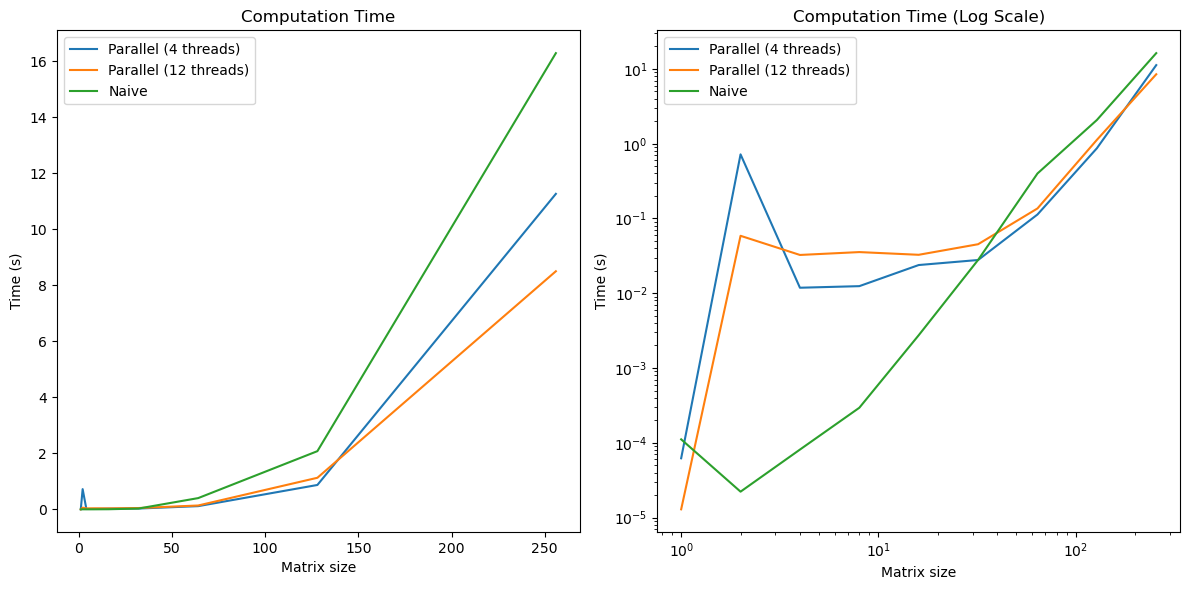

In [276]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot with plt.plot
axs[0].plot(sizes, s_t, label="Parallel (4 threads)")  
axs[0].plot(sizes, sb_t, label="Parallel (12 threads)")
axs[0].plot(sizes, n_t, label="Naive")
axs[0].set_xlabel("Matrix size")
axs[0].set_ylabel("Time (s)")
axs[0].set_title("Computation Time")
axs[0].legend()

# Second subplot with plt.loglog
axs[1].loglog(sizes, s_t, label="Parallel (4 threads)")  
axs[1].loglog(sizes, sb_t, label="Parallel (12 threads)")
axs[1].loglog(sizes, n_t, label="Naive")
axs[1].set_xlabel("Matrix size")
axs[1].set_ylabel("Time (s)")
axs[1].set_title("Computation Time (Log Scale)")
axs[1].legend()

plt.tight_layout()
plt.show()

As can be seen, the four-thread version can actually be faster than the twelve-thread version, due to the increased overhead of managing multiple threads (in particular memory-access locks).
The right-hand plot shows the same data on log-scales. Clearly, for small matrix sizes, the multi-threading overhead outweighs even the costs of the naive algorithm.